# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from scipy.stats import norm
from scipy.stats import ttest_ind, ttest_rel, ranksums, wilcoxon
import seaborn as sns

In [2]:
from backend import data_paths
from backend import evaluation_utils

# Load Return Period Metrics

In [3]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_v3_REANALYSIS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_v3_REANALYSIS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [4]:
from backend import data_paths
from backend import evaluation_utils
# from backend import gauge# Load Return Period Metrics

_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_v3_REANALYSIS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_v3_REANALYSIS_1980_RETURN_PERIOD_METRICS_DIR,
}

precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Calculate F1 Scores from Precision & Recall

In [5]:
f1s_by_lead_time = {
    dataset: {
        experiment: {
            lead_time:
              evaluation_utils.f1_from_precision_and_recall_dfs(
                  precision_df=precisions_by_lead_time[dataset][experiment][lead_time],
                  recall_df=recalls_by_lead_time[dataset][experiment][lead_time]
              ) for lead_time in data_paths.LEAD_TIMES
        } for experiment in precisions_by_lead_time[dataset]
    } for dataset in _DATASET_RETURN_PERIOD_METRICS_PATH
}

# Precision & Recall Distributions with Lead Time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_131846/1826219301.py:40: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7fd3104e3f10> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_131846/1826219301.py:40: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7fd3104f0b50> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_131846/1826219301.py:40: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7fd3104f1550> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_131846/1826219301.py:40: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7fd3104f1f50> starts with '_'. It is thus excluded from the legend.
  ax.legend(
/tmp/ipykernel_131846/1826219301.py:40: UserWarning: The label '_' of <matplotlib.lines.Lin

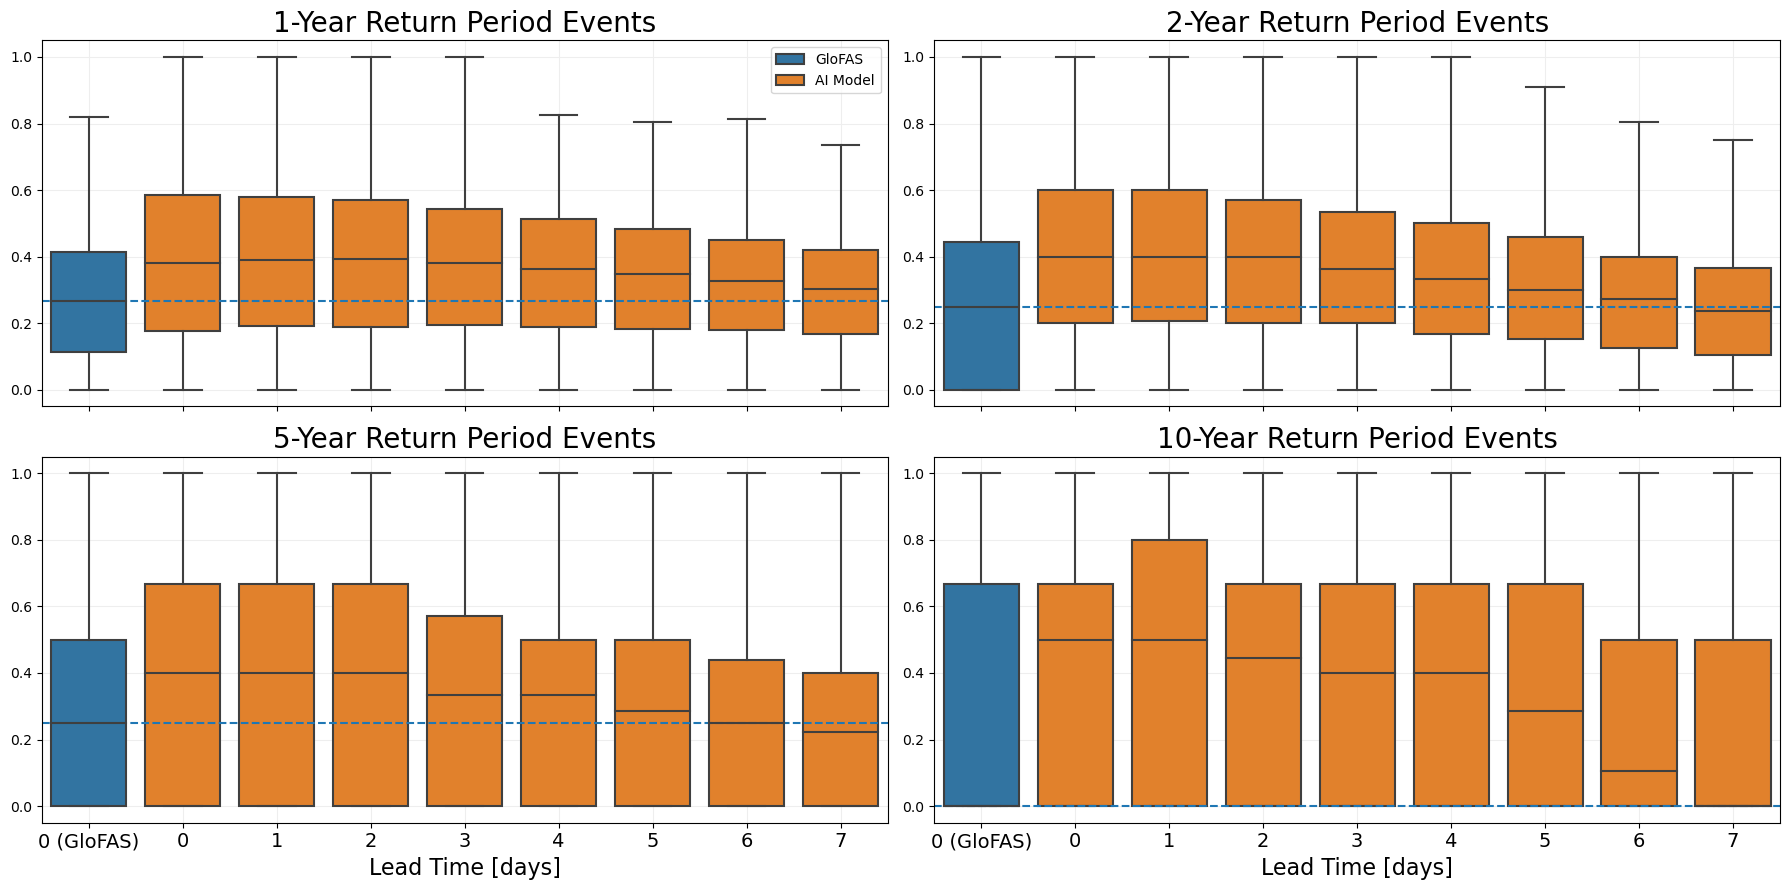

In [6]:
google_dataset = 'google_2014'
google_experiment = 'kfold_splits'
glofas_dataset = 'glofas_2014'
glofas_experiment = 'glofas_reanalysis'

fig, axes = plt.subplots(2, 2, figsize=(18, 9))

for ax, return_period in zip(axes.flatten(), evaluation_utils.RETURN_PERIODS[:-2]):

    # Plot GloFAS.
    dfs = [
        f1s_by_lead_time[glofas_dataset][glofas_experiment][0][return_period].rename(evaluation_utils.EXPERIMENT_NAMES[glofas_experiment])
    ]
    dfs = dfs + [
        f1s_by_lead_time[google_dataset][google_experiment][lead_time][return_period].rename(lead_time) for lead_time in data_paths.LEAD_TIMES
    ]
    df = pd.concat(dfs, axis=1).dropna()

    df.rename(columns={evaluation_utils.EXPERIMENT_NAMES[glofas_experiment]: '0 (GloFAS)'}, inplace=True)

    boxplot_colors = {'0 (GloFAS)': evaluation_utils.COLORS[0]}
    boxplot_colors.update({lead_time: evaluation_utils.COLORS[1] for lead_time in data_paths.LEAD_TIMES})
    bp = sns.boxplot(ax=ax, data=df, showfliers=False, palette=boxplot_colors)
    ax.grid(c='#EEE')
    ax.set_axisbelow(True)
    if ax == axes[0, 0]:
        ax.legend(loc='upper right')
    else:
        ax.legend().remove()
    ax.set_title(f'{int(return_period)}-Year Return Period Events', fontsize=20)
    if ax in axes[0, :]:
        ax.set_xlabel(None)
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Lead Time [days]', fontsize=16)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)


    if ax == axes[0, 0]:
        ax.legend(
            [
                evaluation_utils.EXPERIMENT_NAMES[glofas_experiment]
            ] + ['_']*5 + [evaluation_utils.EXPERIMENT_NAMES[google_experiment],]
        )
    ax.plot(
        [-0.5, 8.5],
        [df['0 (GloFAS)'].median()]*2,
        c=evaluation_utils.COLORS[0],
        ls='--'
    )

plt.tight_layout()

evaluation_utils.save_figure(data_paths.LEAD_TIME_RELIABILITY_DISTRIBUTIONS_FILENAME)

# Statistical Significance of Differences with GloFAS

In [27]:
google_dataset = 'google_2014'
google_experiment = 'kfold_splits'
glofas_dataset = 'glofas_2014'
glofas_experiment = 'glofas_reanalysis'

for return_period in [2, 5, 10]:
    for lead_time in data_paths.LEAD_TIMES:
        df = pd.concat(
            [
                f1s_by_lead_time[glofas_dataset][glofas_experiment][0][return_period].rename(evaluation_utils.EXPERIMENT_NAMES[glofas_experiment]).rename('glofas'),
                f1s_by_lead_time[google_dataset][google_experiment][lead_time][return_period].rename(lead_time)
            ], 
        axis=1
        ).dropna()
        
        print(f'--- {return_period = } --- {lead_time = } ------------------------------------')
        print('Mean Difference:', (df['glofas'] - df[lead_time]).mean())
        stats = wilcoxon(df['glofas'], df[lead_time])
        cohen_d = evaluation_utils.cohen_d(df[lead_time].values, df['glofas'].values)
        zstatistic = norm.isf(stats.pvalue / 2)
        n = df.shape[0]
        effect_size = zstatistic / n**(1/2)
        print(stats, effect_size, cohen_d, n)
        print('---------------------------------------------------------------------\n')

--- return_period = 2 --- lead_time = 0 ------------------------------------
Mean Difference: -0.1268383343164204
WilcoxonResult(statistic=323557.5, pvalue=6.545987078219151e-75) 0.41448995924100934 0.4923151607673985 1952
---------------------------------------------------------------------

--- return_period = 2 --- lead_time = 1 ------------------------------------
Mean Difference: -0.12727864895059068
WilcoxonResult(statistic=315418.0, pvalue=6.644590305140068e-78) 0.4238775435954061 0.49765811148317585 1943
---------------------------------------------------------------------

--- return_period = 2 --- lead_time = 2 ------------------------------------
Mean Difference: -0.11212332119496166
WilcoxonResult(statistic=347951.0, pvalue=5.996781867605749e-65) 0.38608490164222187 0.44431834616325117 1943
---------------------------------------------------------------------

--- return_period = 2 --- lead_time = 3 ------------------------------------
Mean Difference: -0.09075350712832762
